# Text Classification  -  Sentiment Analysis

##  Load required packages

In [14]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
%matplotlib inline

from nltk.corpus import stopwords
from nltk.tokenize.regexp import RegexpTokenizer


## Load and prepare the data

### Load the data

In [15]:
# load the data
data = pd.read_csv("/redoute_v3.csv")


In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Clean the comment's text

In [17]:
# Clean comments : remove number, punctuation, keep only alphabetic string chains word length >= 2
# remove stop words
# and convert to lower case

#non_discrimant_words = ["redoute", "commande", "redoute", "achat","livraison", "article", "articles", "produit", "produits"]
added_stopwords = ["leur", "leurs", "avoir", "cela", "les", "de", "pour", "des", "cette", "a",
                   "jai", "car", "cest", "chez", "tout", "fait", "chez", "donc",
                   "nest", "si", "alors", "nai", "faire", "deux", "comme", "jour", "tr", "si", "ue"]
stop_words = set(stopwords.words('french'))  | set(added_stopwords) #| set(non_discrimant_words)

def clean_text(txt):
    #keep only alphabetic string with lenght >= 2
    tokenizer = RegexpTokenizer(r"[a-zA-Zéàèêùïîûôöëäüç']{2,}")
    #tokenizer = RegexpTokenizer(r"[^0-9#$%:/]{2,}")
    tokens = tokenizer.tokenize(txt.lower())
    txt_cleaned = ""
    for mot in tokens:
        #filter stopwords
        if mot not in stop_words:
            txt_cleaned = txt_cleaned + mot + " "
    return txt_cleaned

# clean all comments
data["comment_cleaned"] = data["comment"].apply(clean_text)

data.head(1)


,id,rating,title,comment,createdAt,transaction,SupplierReply,SupplierReplyDate,date_of_cmt,year_of_cmt,...,month_of_transaction,day_of_transaction,weekday_of_transaction,transaction_in_weekend,transaction_date,comment_length,log_comment_length,title_length,nb_days_before_review,comment_cleaned
0,rev-cc907a30-4fb0-4e55-a4a1-307b89eb0d99,4,Facilte,"Facilte, sollicitations dosées...qualité..on p...",2023-10-05 14:18:42,2023-09-23,NaN,NaN,2023-10-05,2023,...,9,23,5,1,2023-09-23,1049,6.955593,7,12.0,facilte sollicitations dosées qualité pourrait...


In [18]:
! pip install transformers

import torch
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 40.7 MB/s eta 0:00:00


In [19]:
df = data[["comment_cleaned", "rating"]]
df["target"] = np.where(df["rating"]>=4, 1, 0)
df.head()

,comment_cleaned,rating,target
0,facilte sollicitations dosées qualité pourrait...,4,1
1,livraison impeccable possibilité prendre rdv s...,4,1
2,achat d'un canapé redoute intérieurs site redo...,4,1
3,commande depuis longtemps redoute j'y apprécia...,4,1
4,d'habitude aucun souci rapidité d'expédition c...,5,1


In [20]:
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [21]:
def sentiment_score(comment):
	token = tokenizer.encode(comment, return_tensors = 'pt')
	result = model(token)
	return int(torch.argmax(result.logits))+1

In [ ]:
df["bert_sentiment"] = df['comment_cleaned'].apply(lambda x: sentiment_score(x[:512]))
df.to_csv("data_bert_sentiment.csv")

In [ ]:
df["bert_target"] = np.where(df["bert_sentiment"] >=4, 1, 0)

In [ ]:
print("**** Crosstab of bert_sentiment versus rating ****")
display(pd.crosstab(df["rating"], df["bert_sentiment"]))

print("\n")
print("**** Crosstab of bert_target versus target ****")
display(pd.crosstab(df["target"], df["bert_target"]))

print("\n")
print("**** Classification report ****")

from sklearn import metrics
print(metrics.classification_report(df["target"], df["bert_target"]))

**** Crosstab of bert_sentiment versus rating ****


bert_sentiment,1,2,3,4,5
rating,,,,,
1,589,47,63,30,31
2,470,110,75,34,23
3,554,248,282,75,69
4,316,185,766,1035,1441
5,387,180,894,4136,11429




**** Crosstab of bert_target versus target ****


bert_target,0,1
target,,
0,2438,262
1,2728,18041




**** Classification report ****
              precision    recall  f1-score   support

           0       0.47      0.90      0.62      2700
           1       0.99      0.87      0.92     20769

    accuracy                           0.87     23469
   macro avg       0.73      0.89      0.77     23469
weighted avg       0.93      0.87      0.89     23469



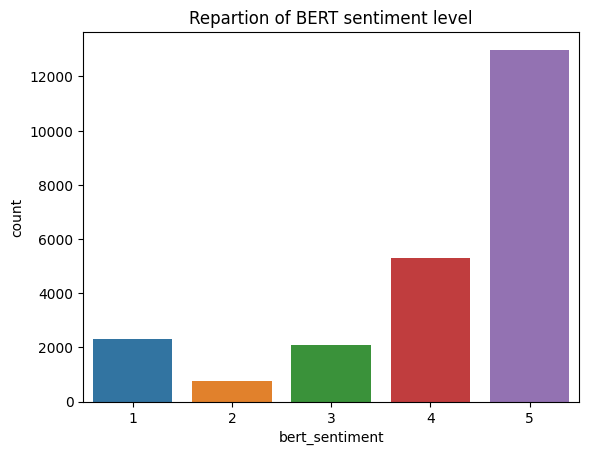

In [ ]:
sns.countplot(data = df, x = "bert_sentiment")
plt.title("Repartion of BERT sentiment level")
plt.show()

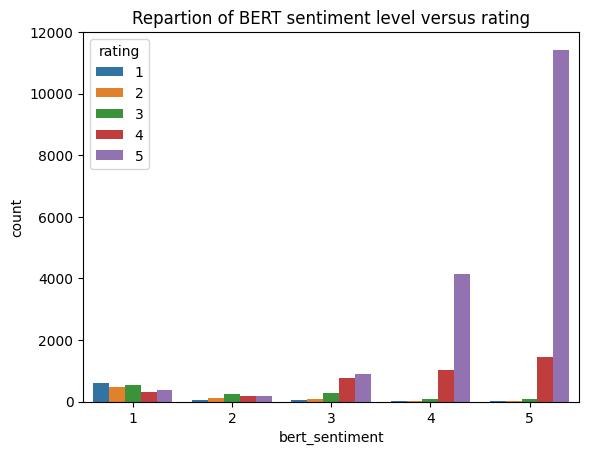

In [ ]:
sns.countplot(data = df, x = "bert_sentiment", hue = "rating")
plt.title("Repartion of BERT sentiment level versus rating")
plt.show()

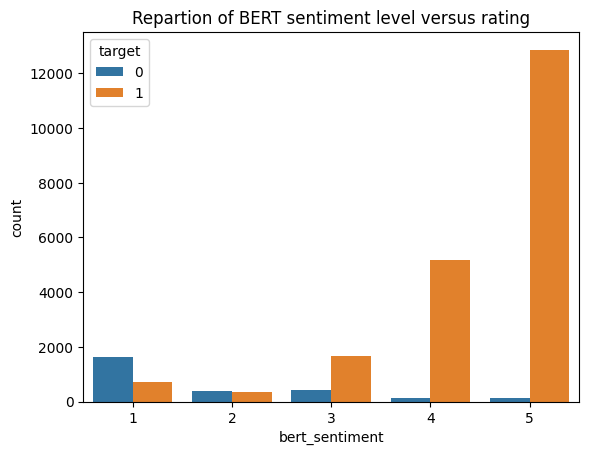

In [ ]:
sns.countplot(data = df, x = "bert_sentiment", hue = "target")
plt.title("Repartion of BERT sentiment level versus rating")
plt.show()

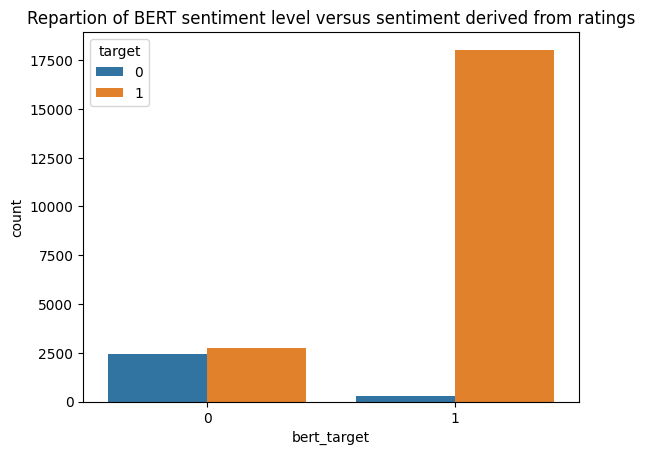

In [ ]:
sns.countplot(data = df, x = "bert_target", hue = "target")
plt.title("Repartion of BERT sentiment level versus sentiment derived from ratings")
plt.show()

## Zoom in

In [ ]:
dz = df[(df["rating"]==5) & (df["bert_sentiment"]==1)]
for i in range(10):
  print(dz.iloc[i,0])
dz.head()

d'habitude aucun souci rapidité d'expédition colis bravo dommage puisse plus payer carte premium facilités paiement j'avais reçu courrier demandant mise dossier sofinco auquel c'est vrai n'ai répondu trouvant trop personnel renseignements demandés montant rémunération mensuelle comprendre j'ai toujours réglé heureusement achats sans problème temps depuis nombreuses années fais partie personnes achètent sans pouvoir peut être dû ge voilà j'ai fini rédaction salutations mme rouchon 
j'ai aimé disponibilité produit commandé ainsi livraison domicile j'ai déploré comportement livreur très pressé n'a pris temps lire bon livraison retour l'ancien matelas j'avais vu messenger rajoute commande mention reprise l'ancien objet livré n'est précisé lors validation commande faite mention descriptif produit vendu après ppfftt plus rien 
c'est ère fois commande redoute internet déçue très satisfaite rapidité laquelle j'ai reçu colis peine jours entre commande livraison qualité marchandise bien attentes

,comment_cleaned,rating,target,bert_sentiment,bert_target
4,d'habitude aucun souci rapidité d'expédition c...,5,1,1,0
13,j'ai aimé disponibilité produit commandé ainsi...,5,1,1,0
42,c'est ère fois commande redoute internet déçue...,5,1,1,0
61,commande rapidement envoyée possibilité retour...,5,1,1,0
75,colis reçu annoncé sauf livreur s'est servi pa...,5,1,1,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')